# Cluster Analysis Course Notebook

### Importing Data files

In [165]:
# The code was removed by Watson Studio for sharing.

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [166]:
#Import Transaction DataSet here
body = client_1db92c7017d54886831046b32d9ea878.get_object(Bucket='project1-donotdelete-pr-fak4pf0yfksumo',Key='Transaction Data Set - Student 3 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

transactions_data = pd.read_csv(body,sep='|')
transactions_data.head()


,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [167]:
#Import Customer Dataset Here
body = client_1db92c7017d54886831046b32d9ea878.get_object(Bucket='project1-donotdelete-pr-fak4pf0yfksumo',Key='Customer Data Set - Student 1 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customer_data = pd.read_csv(body)
customer_data.head()


,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


### Changing data types

In [168]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))

In [169]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

### Creating Customer View

In [170]:
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

In [171]:
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))

In [172]:
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

In [173]:
trans_products.head()

,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE,Total_Price
0,10114,30011,4,0.0,1/2/2015,0,30011,APPAREL,25.46,101.840
1,10086,30011,6,0.0,1/2/2015,0,30011,APPAREL,25.46,152.760
2,10174,30011,10,0.0,1/2/2015,0,30011,APPAREL,25.46,254.600
3,10401,30011,12,0.0,1/2/2015,0,30011,APPAREL,25.46,305.520
4,10216,30011,12,0.1,1/2/2015,0,30011,APPAREL,25.46,274.968


In [174]:
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})

In [175]:
customer_prod_categ=customer_prod_categ.reset_index()

In [176]:
customer_prod_categ.head()

,CUSTOMER NUM,PRODUCT CATEGORY,Total_Price
0,10001,APPAREL,4022.430
1,10001,ELECTRONICS,1601.315
2,10001,FOOD,68.688
3,10001,HEALTH & BEAUTY,1134.337
4,10002,APPAREL,2312.509


In [177]:
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

In [178]:
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

In [179]:
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )

In [180]:
customer_KPIs=customer_KPIs.fillna(0)


In [181]:
customer_KPIs.head()

,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
CUSTOMER NUM,,,,,
10001,4022.430,1601.315,68.688,1134.337,6826.770
10002,2312.509,2473.163,276.779,0.000,5062.451
10003,2887.382,5414.418,260.640,0.000,8562.440
10004,3637.213,1840.211,45.270,0.000,5522.694
10005,213.512,0.000,0.000,0.000,213.512


In [182]:
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)

In [183]:
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


# Clustering  

In [184]:
#Begin Writing your code here
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

cluster_input=customer_all_view[['INCOME', 'TOTAL SPENT']]
cluster_input.head(5)

,INCOME,TOTAL SPENT
0,133498,6826.770
1,94475,5062.451
2,88610,8562.440
3,84313,5522.694
4,51498,213.512


In [185]:
Kmeans_model=KMeans(n_clusters=4)
Kmeans_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [186]:
cluster_output = Kmeans_model.fit_predict(cluster_input)
cluster_output

array([3, 2, 2, 2, 1, 3, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 2, 0, 3, 1, 0, 0,
       0, 1, 0, 0, 2, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 2,
       3, 1, 1, 2, 3, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 3, 0, 3, 2,
       2, 0, 1, 2, 2, 1, 1, 2, 3, 1, 2, 1, 2, 3, 2, 0, 3, 0, 1, 0, 3, 1,
       2, 1, 0, 3, 0, 0, 0, 2, 0, 1, 3, 0, 1, 1, 1, 1, 2, 0, 0, 1, 2, 1,
       1, 1, 2, 1, 0, 1, 3, 3, 2, 2, 1, 2, 0, 1, 2, 2, 0, 2, 1, 3, 2, 2,
       1, 2, 3, 2, 3, 3, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0,
       2, 0, 1, 1, 0, 1, 3, 1, 3, 0, 1, 2, 1, 3, 2, 1, 3, 1, 0, 0, 3, 1,
       3, 3, 0, 1, 3, 1, 2, 1, 0, 3, 0, 0, 1, 3, 1, 0, 0, 3, 0, 3, 0, 3,
       0, 2, 0, 1, 3, 3, 0, 1, 2, 3, 3, 3, 3, 1, 0, 2, 3, 0, 1, 0, 2, 1,
       2, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 0, 3, 1, 1, 1, 2,
       2, 2, 2, 1, 0, 0, 3, 1, 2, 0, 1, 0, 1, 2, 1, 3, 0, 0, 1, 3, 1, 2,
       2, 3, 0, 2, 2, 0, 3, 1, 3, 1, 1, 1, 3, 2, 0, 0, 0, 2, 2, 2, 3, 2,
       0, 2, 0, 3, 3, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1,

In [187]:
type(cluster_output)

numpy.ndarray

In [188]:
#Converts the array into a dataframe
cluster_output_pd=pd.DataFrame(cluster_output,columns=['segment'])
cluster_output_pd.head()

,segment
0,3
1,2
2,2
3,2
4,1


In [189]:
product_data.head()
product_data.head().values
product_data.head().values[1,2]
product_data.head().values[1,:]
product_data.head().values[:,2]
#Merges the cluster input containing the income and total spending for each customer and the cluster output, which contains the cluster index
segment_DF=pd.concat([cluster_input,cluster_output_pd],axis=1)
segment_DF.head()

,INCOME,TOTAL SPENT,segment
0,133498,6826.770,3
1,94475,5062.451,2
2,88610,8562.440,2
3,84313,5522.694,2
4,51498,213.512,1


In [190]:
#Calculates/Gives the cluster centroids
Kmeans_model.cluster_centers_

array([[111789.98360656,   7856.9202541 ],
       [ 40510.09803922,   2472.75349673],
       [ 79703.36956522,   5428.75010145],
       [138629.34482759,   6996.87572414]])

In [191]:
Kmeans_model.cluster_centers_[:,0]

array([111789.98360656,  40510.09803922,  79703.36956522, 138629.34482759])

In [192]:
#To select only those segments that belong to the first cluster (cluster index=0)
segment_DF[segment_DF.segment==0].head()

,INCOME,TOTAL SPENT,segment
7,115672,8412.001,0
8,101741,9116.576,0
11,101805,293.100,0
17,112035,4242.889,0
20,105964,5957.315,0


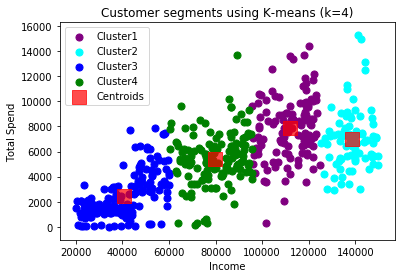

In [193]:
import matplotlib.pyplot as plt
plt.scatter(segment_DF[segment_DF.segment==0]['INCOME'],segment_DF[segment_DF.segment==0]['TOTAL SPENT'],s=50, c='purple',label='Cluster1')
plt.scatter(segment_DF[segment_DF.segment==3]['INCOME'],segment_DF[segment_DF.segment==3]['TOTAL SPENT'],s=50, c='cyan',label='Cluster2')
plt.scatter(segment_DF[segment_DF.segment==1]['INCOME'],segment_DF[segment_DF.segment==1]['TOTAL SPENT'],s=50, c='blue',label='Cluster3')
plt.scatter(segment_DF[segment_DF.segment==2]['INCOME'],segment_DF[segment_DF.segment==2]['TOTAL SPENT'],s=50, c='green',label='Cluster4')
#Centroids of the plot
plt.scatter(Kmeans_model.cluster_centers_[:,0], Kmeans_model.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Customer segments using K-means (k=4)')
plt.xlabel('Income')
plt.ylabel('Total Spend')
plt.legend()
plt.show()



In [194]:
customer_demographics=pd.concat([customer_all_view,cluster_output_pd],axis=1)
customer_demographics.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT,segment
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770,3
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451,2
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440,2
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694,2
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512,1


In [195]:
#different customer segments demographics: Age, Household size
customer_demographics=pd.concat([customer_all_view,cluster_output_pd],axis=1)
customer_demographics.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT,segment
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770,3
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451,2
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440,2
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694,2
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512,1


In [196]:
def percent_loyalty(series):
    percent=100 * series.value_counts()['enrolled'] /series.count()
    return percent

In [198]:
#Adds percentage loyalty
customer_demographics.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median','LOYALTY GROUP': percent_loyalty})

,AGE,HOUSEHOLD SIZE,LOYALTY GROUP
segment,,,
0,48.032787,3.0,68.852459
1,25.104575,2.0,50.326797
2,36.615942,3.5,33.333333
3,73.609195,2.0,65.517241


## Agglomerative Clustering

In [199]:
AgglomerativeClustering_model=AgglomerativeClustering(n_clusters=4)
AgglomerativeClustering_model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [164]:
cluster_output_2=AgglomerativeClustering_model.fit_predict(cluster_input)
cluster_output_2

array([0, 3, 3, 3, 1, 0, 1, 0, 3, 1, 2, 3, 3, 3, 1, 3, 3, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 2, 2, 0, 1, 2, 2, 3, 2, 2, 1, 0, 0, 1, 2, 1, 1, 1,
       0, 2, 2, 1, 0, 1, 0, 2, 1, 1, 3, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 1,
       3, 0, 2, 1, 1, 2, 1, 1, 0, 2, 3, 2, 1, 0, 1, 0, 0, 0, 1, 3, 0, 1,
       3, 2, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 2, 2, 1, 2, 1, 3, 0, 2, 1, 1,
       2, 2, 1, 2, 3, 1, 0, 0, 1, 1, 2, 3, 0, 2, 3, 1, 0, 1, 2, 0, 1, 3,
       1, 3, 0, 3, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 3, 2, 3, 1, 3, 0, 0, 0,
       3, 3, 1, 1, 0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 2, 0, 2, 0, 3, 0, 1,
       0, 0, 3, 2, 0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 3, 0, 0, 0,
       0, 3, 3, 2, 0, 0, 3, 2, 3, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 3, 1, 1,
       1, 2, 0, 1, 1, 1, 0, 2, 2, 3, 3, 1, 0, 3, 3, 2, 0, 0, 1, 1, 2, 1,
       3, 3, 1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 2, 1, 2, 0, 0, 3, 2, 0, 1, 3,
       3, 0, 3, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 3, 3, 1, 3, 0, 1,
       0, 3, 0, 0, 0, 2, 2, 0, 2, 1, 2, 2, 1, 3, 2,

In [201]:
cluster_output_2_pd=pd.DataFrame(cluster_output_2,columns=['segment'])
cluster_output_2_pd.head()

,segment
0,0
1,3
2,3
3,3
4,1


In [202]:
segment_DF_2=pd.concat([cluster_input,cluster_output_2_pd],axis=1)
segment_DF_2.head()

,INCOME,TOTAL SPENT,segment
0,133498,6826.770,0
1,94475,5062.451,3
2,88610,8562.440,3
3,84313,5522.694,3
4,51498,213.512,1


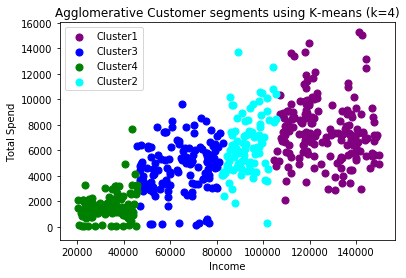

In [203]:
plt.scatter(segment_DF_2[segment_DF_2.segment==0]['INCOME'],segment_DF_2[segment_DF_2.segment==0]['TOTAL SPENT'],s=50, c='purple',label='Cluster1')
plt.scatter(segment_DF_2[segment_DF_2.segment==1]['INCOME'],segment_DF_2[segment_DF_2.segment==1]['TOTAL SPENT'],s=50, c='blue',label='Cluster3')
plt.scatter(segment_DF_2[segment_DF_2.segment==2]['INCOME'],segment_DF_2[segment_DF_2.segment==2]['TOTAL SPENT'],s=50, c='green',label='Cluster4')
plt.scatter(segment_DF_2[segment_DF_2.segment==3]['INCOME'],segment_DF_2[segment_DF_2.segment==3]['TOTAL SPENT'],s=50, c='cyan',label='Cluster2')
plt.title('Agglomerative Customer segments using K-means (k=4)')
plt.xlabel('Income')
plt.ylabel('Total Spend')
plt.legend()
plt.show()

In [204]:
customer_demographics_2=pd.concat([customer_all_view,cluster_output_2_pd],axis=1)
customer_demographics_2.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT,segment
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770,0
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451,3
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440,3
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694,3
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512,1


In [205]:
customer_demographics_2.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median'})

,AGE,HOUSEHOLD SIZE
segment,,
0,61.382022,3
1,32.430769,3
2,22.620000,2
3,40.804348,4


In [206]:
customer_demographics_2.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median','LOYALTY GROUP': percent_loyalty})

,AGE,HOUSEHOLD SIZE,LOYALTY GROUP
segment,,,
0,61.382022,3,70.224719
1,32.430769,3,33.846154
2,22.620000,2,58.000000
3,40.804348,4,40.217391
